In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torchvision.models as models
from torchinfo import summary


import numpy as np
from numpy import linalg as LA
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def load_img(file_path, channel = "R"):
    with open(file_path) as f:
        lines = f.readlines()
    imgs, labels = [], []
    target_size=(128, 128)
    print('Total images:', len(lines))
    for i in tqdm(range(len(lines)), desc="Loading images"):
    # for i in tqdm(range(100), desc="Loading images"):
        fn, label = lines[i].strip().split(' ')
        im1 = cv2.imread(fn)
        # 如果需要進行影像處理，請在這裡添加相應的處理步驟
        im1 = cv2.resize(im1, target_size)


        # 把圖片RGB都拆開
        im1_r, im1_g, im1_b = im1[:, :, 0], im1[:, :, 1], im1[:, :, 2]
        if channel == "R":
            im1_r = np.expand_dims(im1_r, axis=2)
            im1_r_tensor = torch.from_numpy(im1_r.transpose(2, 0, 1))
            imgs.append(im1_r_tensor)
            labels.append(int(label))
        elif channel == "G":
            im1_g = np.expand_dims(im1_g, axis=2)
            im1_g_tensor = torch.from_numpy(im1_g.transpose(2, 0, 1))
            imgs.append(im1_g_tensor)
            labels.append(int(label))
        elif channel == "B":
            im1_b = np.expand_dims(im1_b, axis=2)
            im1_b_tensor = torch.from_numpy(im1_b.transpose(2, 0, 1))
            imgs.append(im1_b_tensor)
            labels.append(int(label))
        elif channel == "RG":
            im1_rg = im1[:, :, 0:2]
            im1_rg_tensor = torch.from_numpy(im1_rg.transpose(2, 0, 1))
            imgs.append(im1_rg_tensor)
            labels.append(int(label))
            # print(im1_rg.shape)
        elif channel == "GB":
            im1_gb = im1[:, :, 1:3]
            im1_gb_tensor = torch.from_numpy(im1_gb.transpose(2, 0, 1))
            imgs.append(im1_gb_tensor)
            labels.append(int(label))
            # print(im1_gb.shape)
        elif channel == "RB":
            im1_rb = im1[:, :, [0, 2]]
            im1_rb_tensor = torch.from_numpy(im1_rb.transpose(2, 0, 1))
            imgs.append(im1_rb_tensor)
            labels.append(int(label))
            # print(im1_rb.shape)
        else:
            # 轉換成 PyTorch Tensor
            im1_tensor = torch.from_numpy(im1.transpose(2, 0, 1))  # 將通道維度移動到最前面
            imgs.append(im1_tensor)
            labels.append(int(label))
    
    imgs_tensor = torch.stack(imgs)  # 將列表中的 Tensor 堆疊成一個整體 Tensor
    labels_tensor = torch.tensor(labels)

    return imgs_tensor, labels_tensor


channel = "B"
x, y = load_img('train.txt',channel)
val_x, val_y = load_img('val.txt',channel)
tx, ty = load_img('test.txt',channel)

Total images: 63325


Loading images: 100%|██████████| 63325/63325 [00:24<00:00, 2574.01it/s]


Total images: 450


Loading images: 100%|██████████| 450/450 [00:00<00:00, 2566.25it/s]


Total images: 450


Loading images: 100%|██████████| 450/450 [00:00<00:00, 2586.27it/s]


In [3]:

batch_size = 128  # 可以自行調整 batch size 的大小
shuffle = True   # 是否對資料進行洗牌


y_tensor = torch.nn.functional.one_hot(y, num_classes=50)
val_y_tensor = torch.nn.functional.one_hot(val_y, num_classes=50)
ty_tensor = torch.nn.functional.one_hot(ty, num_classes=50)

train_dataset = TensorDataset(x, y_tensor)
val_dataset = TensorDataset(val_x, val_y_tensor)
test_dataset = TensorDataset(tx, ty_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)


In [4]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # if test RGB in_channels = 3
        # if test RG, GB, RB in_channels = 2
        # if test R, G, B in_channels = 1
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)


        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(512 * 4 * 4, 1024) 
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 50)
        

        self.dropout = nn.Dropout(0.5)

    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        
        # print(x.shape)
        x = self.flatten(x)
        # print(x.shape)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [5]:
model = CNNModel()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # 檢查是否有 GPU，有則使用 GPU
model.to(device)  # 將模型移動到設備上

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_fea

In [6]:
summary(model)

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            295,168
├─Conv2d: 1-5                            1,180,160
├─BatchNorm2d: 1-6                       64
├─BatchNorm2d: 1-7                       128
├─BatchNorm2d: 1-8                       256
├─BatchNorm2d: 1-9                       512
├─BatchNorm2d: 1-10                      1,024
├─MaxPool2d: 1-11                        --
├─Flatten: 1-12                          --
├─Linear: 1-13                           8,389,632
├─Linear: 1-14                           524,800
├─Linear: 1-15                           25,650
├─Dropout: 1-16                          --
Total params: 10,510,066
Trainable params: 10,510,066
Non-trainable params: 0

In [7]:
def train(model,traindataloader,valdataLoader,criterion,optimizer,traing_acc,val_acc,epoch,channel):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    
    running_loss = 0.0
    for inputs, labels in tqdm(traindataloader):
        # print(inputs[0].shape)
        inputs, labels = inputs.float().to(device), labels.float().to(device)  # 將數據移動到設備上

        # 正向傳播
        outputs = model(inputs)
        # print(type(outputs))
        loss = criterion(outputs, labels)

        # 反向傳播和優化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        labels = labels.argmax(dim=1)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        running_loss += loss.item() * inputs.size(0)
    
    traing_acc.append(100 * train_correct / train_total)

    model.eval()  # 將模型設置為評估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valdataLoader:
            inputs, labels = inputs.float().to(device), labels.float().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            labels = labels.argmax(dim=1)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    val_acc.append(100 * correct / total)


    epoch_loss = running_loss / len(traindataloader.dataset)
    print(f"Epoch {epoch + 1}/{10}, Loss: {epoch_loss:.4f}, channel = {channel}, Training Accuracy: {100 * train_correct / train_total:.2f}%, Validation Accuracy: {100 * correct / total:.2f}%")

In [8]:
def plot_acc(train_acc,val_acc,channel):
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"./results/HW2-1/naive_Model/naiveModel_{channel}_accuracy_plot.png")
    plt.show()

100%|██████████| 495/495 [00:13<00:00, 35.70it/s]


Epoch 1/10, Loss: 3.5799, channel = B, Training Accuracy: 7.25%, Validation Accuracy: 13.33%


100%|██████████| 495/495 [00:13<00:00, 38.03it/s]


Epoch 2/10, Loss: 3.2350, channel = B, Training Accuracy: 12.04%, Validation Accuracy: 13.33%


100%|██████████| 495/495 [00:11<00:00, 42.42it/s]


Epoch 3/10, Loss: 3.0598, channel = B, Training Accuracy: 14.80%, Validation Accuracy: 17.11%


100%|██████████| 495/495 [00:11<00:00, 42.62it/s]


Epoch 4/10, Loss: 2.9097, channel = B, Training Accuracy: 17.77%, Validation Accuracy: 11.78%


100%|██████████| 495/495 [00:11<00:00, 42.65it/s]


Epoch 5/10, Loss: 2.7776, channel = B, Training Accuracy: 20.61%, Validation Accuracy: 18.44%


100%|██████████| 495/495 [00:11<00:00, 42.41it/s]


Epoch 6/10, Loss: 2.6352, channel = B, Training Accuracy: 23.52%, Validation Accuracy: 26.22%


100%|██████████| 495/495 [00:11<00:00, 42.84it/s]


Epoch 7/10, Loss: 2.4944, channel = B, Training Accuracy: 26.53%, Validation Accuracy: 22.67%


100%|██████████| 495/495 [00:11<00:00, 42.43it/s]


Epoch 8/10, Loss: 2.3528, channel = B, Training Accuracy: 29.98%, Validation Accuracy: 27.11%


100%|██████████| 495/495 [00:11<00:00, 42.59it/s]


Epoch 9/10, Loss: 2.2327, channel = B, Training Accuracy: 32.55%, Validation Accuracy: 34.00%


100%|██████████| 495/495 [00:11<00:00, 42.89it/s]


Epoch 10/10, Loss: 2.1128, channel = B, Training Accuracy: 35.22%, Validation Accuracy: 36.44%


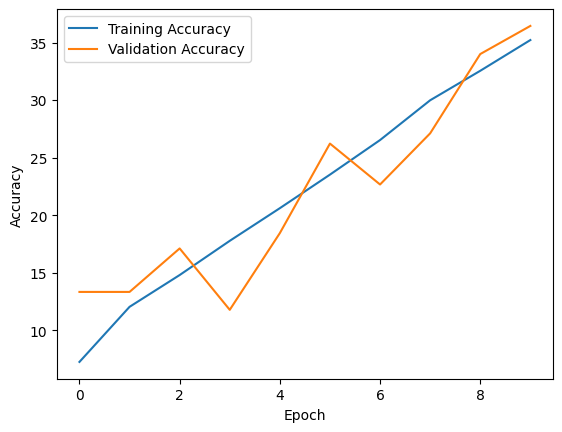

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10 

traing_acc = []
val_acc = []

for epoch in range(epochs):
    model.train()
    train(model,train_loader,val_loader,criterion,optimizer,traing_acc,val_acc,epoch,channel)
    
    
plot_acc(traing_acc,val_acc,channel)




In [10]:
def test(model,test_loader,channel):
    model.eval() 
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.float().to(device), labels.float().to(device)
            labels = labels.argmax(dim=1)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"{channel} test Accuracy: {accuracy:.4f}")

In [11]:
test(model,test_loader,channel)  
# RGB test acc = 0.3911
# RG  test acc = 0.4467
# GB  test acc = 0.4200
# RB  test acc = 0.4200
# R   test acc = 0.3422
# G   test acc = 0.2800
# B   test acc = 0.3444

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 82.64it/s]

B test Accuracy: 0.3444


In [12]:
torch.save(model, f'./model/HW2-1/naiveModel/naiveModel_{channel}.pth')